### Copyright (C) Infineon Technologies AG 2025
 
Use of this file is subject to the terms of use agreed between (i) you or the company in which ordinary course of 
business you are acting and (ii) Infineon Technologies AG or its licensees. If and as long as no such terms of use
are agreed, use of this file is subject to following:
 
This file is licensed under the terms of the Boost Software License. See the LICENSE file in the root of this repository
for complete details.

### Notebook Structure
1. **Dataset**
2. **Project Structure**
3. **Keyword Detection Model**
4. **Adding Input Data**
5. **Export and Save Model and Data**
6. **Compiling the Model for AURIX&trade;**
7. **Execution timing PPU vs TC3**

### Keyword Detection

This project demonstrates a neural network that detects english words in a microphone recording. This can be used for wake word detection or giving commands to a car, such as opening the trunk. 

## Dataset
The dataset used to train the Neural Network is the [Google Speech commands dataset v0.02](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz) which has the following features:

- 35 classes of english words
- 35 speakers
- ~100.000 samples
- noise recordings that can be added to samples (not used in this model)

## Project Structure

```
├── models/
│   ├── KeywordDetecionModel.h5   # Pretrained network
├── out/                          # Example models and generated outputs
│   └── ...                       # Trained models and conversion results
├── keyword_detection.ipynb       # Main analysis notebook
└── metadata.json                 # Information of Deepcraft Studio Accelerator model
```

## Preparation

Importing necessary helper functions.

In [5]:
import os
import sys

import numpy as np

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from CentralScripts.helper_functions import *
from CentralScripts.python_flask_client import CallTools

import modelling_helper as mh

#### Keyword Detection Model

The structure of the trained network is shown in the following class for reference. 

In [6]:
origin = "tf"  # tf stands for TensorFlow
model_name = "KeywordDetectionModel"

# For reference, this is the model structure of the used model
model = mh.get_model(origin)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 50, 16)         │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 50, 16)         │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 50, 16)         │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 50, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 25, 32)         │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 25, 32)         │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 12, 32)         │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 12, 32)         │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 360)            │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 360)            │         1,440 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 36)             │        12,96

 Total params: 98,048 (383.00 KB)

 Trainable params: 97,168 (379.56 KB)

 Non-trainable params: 880 (3.44 KB)

#### Adding Input Data

Now we generate a random input and the corresponding output for model validation.

In [7]:
input_target = np.random.rand(1, 50, 40).astype(np.float32)
output_target = get_predictions(origin, model, input_target)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


#### Export and Save Model and Data

We now export model, input, and output data: 
- the model will be converted into ONNX
- input, and output will be stored as pb.

In [8]:
save_all(model_name, input_target, output_target, model, origin)

Directory already exists: out/KeywordDetectionModel/test_KeywordDetectionModel


#### Compiling the Model for AURIX&trade;

We now generate a C file from the ONNX and convert this into an elf file next. The elf file can be deployed on the CPUs of an AURIX&trade; TC3x. First, we need to ensure that the docker conainer with all tools is available.

In [9]:
ensure_docker_container()

Docker container 'trusting_lewin' (from image 'docker-atv-sae-ai-public-registry.vih.infineon.com/tc_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


Now, we can run the tools container to convert our model to C code with the AURIX&trade; TC3x as target.

In [10]:
model_folder, onnx_model_file = get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

Target folder out/KeywordDetectionModel/test_KeywordDetectionModel/TC3 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
Target folder out/KeywordDetectionModel/test_KeywordDetectionModel/TC4 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


### Execution timing AURIX&trade; TC4x vs AURIX&trade; TC3x

We now compare the execution timings of both target devices.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


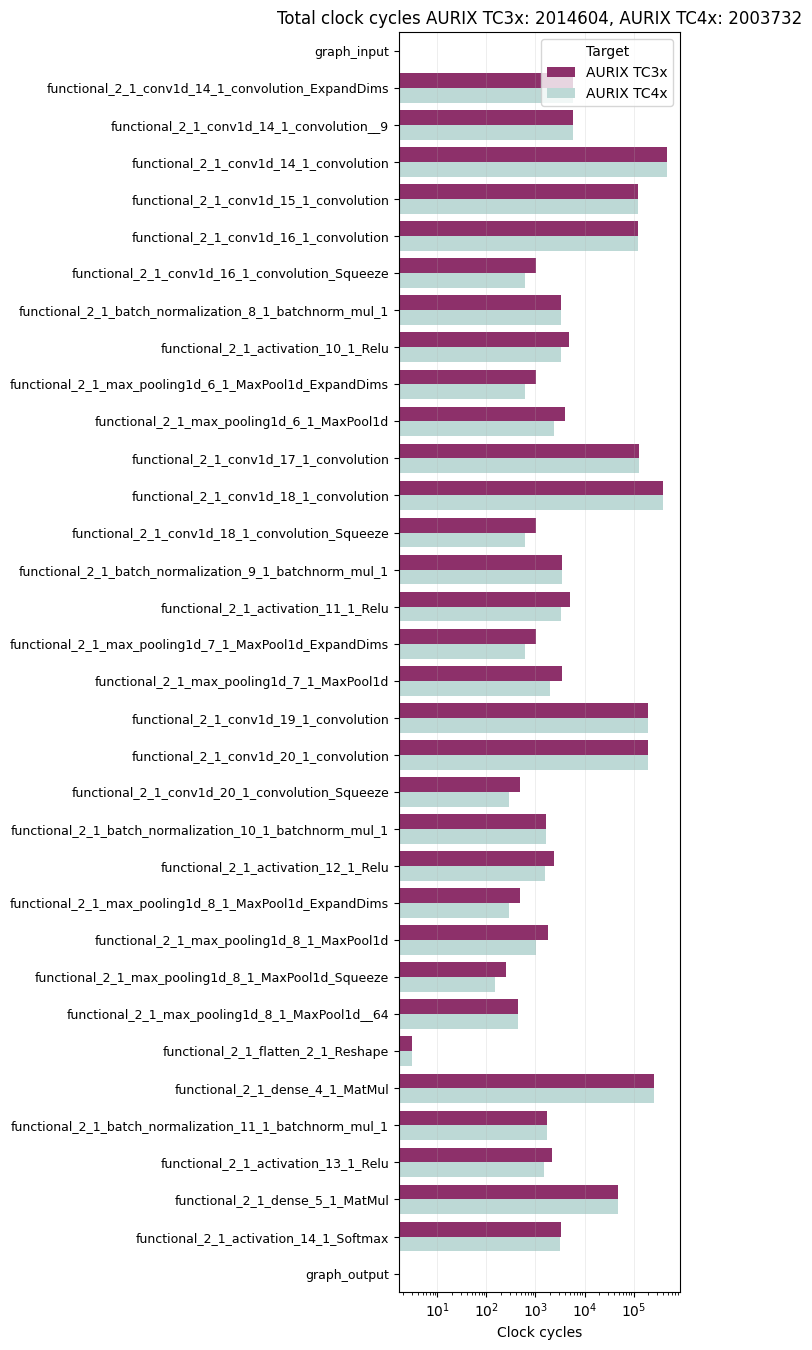

In [11]:
plot_execution_timing(model_name)